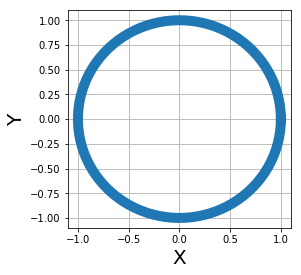

In [91]:
%matplotlib inline
import matplotlib 
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy import integrate
import math

u_inf = 1.0
R = 1.0;
x_center, y_center = 0.0,0.0
Nth = 100
theta = np.linspace(0,2*np.pi,Nth)
x_cyl, y_cyl = x_center + R*np.cos(theta),y_center + R*np.sin(theta)

plt.figure(figsize=(4,4))
plt.plot(x_cyl,y_cyl,linewidth=10)
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)
plt.grid()

In [102]:
class Panel:
    def __init__(self,xa,ya,xb,yb):
        self.xa,self.ya = xa,ya
        self.xb,self.yb= xb,yb
        self.xc,self.yc = (xa+xb)/2,(ya+yb)/2
        self.length =np.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        if xb-xa<=0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa>0:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
            
        self.velocity=0.0
        self.sigma =0.0
        self.cp=0.0
           


In [103]:
Npan=10;
x= R*np.cos(np.linspace(0.0,2*np.pi,Npan+1))
y = R*np.sin(np.linspace(0.0,2*np.pi,Npan+1))
panels=np.empty(Npan,dtype=object)
for i in range(Npan):
    panels[i]= Panel(x[i],y[i],x[i+1],y[i+1])
    

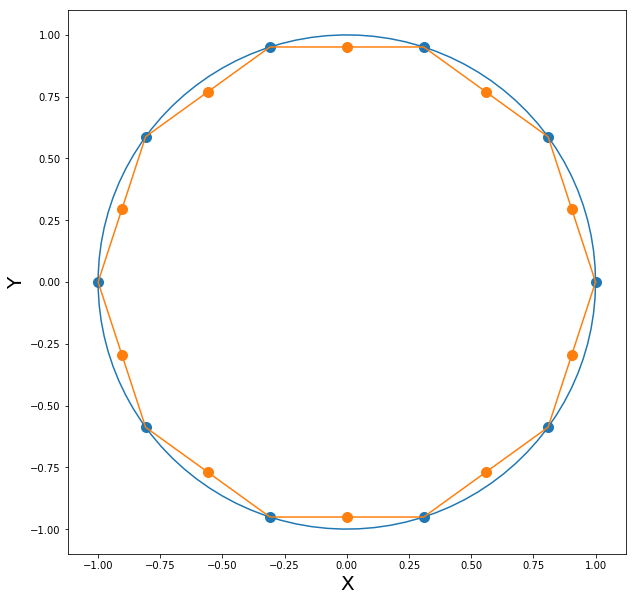

In [104]:
plt.figure(figsize=(10,10))
plt.plot(x_cyl,y_cyl)
plt.plot(x,y)
plt.scatter([p.xa for p in panels], [p.ya for p in panels],s=100)
plt.scatter([p.xc for p in panels], [p.yc for p in panels],s=100)
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)


In [105]:
def integral_normal(p_i,p_j):
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [106]:
# compute the source influence matrix
A = np.empty((Npan, Npan), dtype=float)
np.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / np.pi * integral_normal(p_i, p_j)

# compute the RHS of the linear system
b = -u_inf * np.cos([p.beta for p in panels])




In [107]:
sig = np.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = sig[i]
sig



array([ -2.17594204e+00,  -1.34480614e+00,  -1.12886627e-15,
         1.34480614e+00,   2.17594204e+00,   2.17594204e+00,
         1.34480614e+00,   3.92093559e-16,  -1.34480614e+00,
        -2.17594204e+00])

In [108]:
def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [109]:
A = np.empty((Npan, Npan), dtype=float)
np.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / np.pi * integral_tangential(p_i, p_j)


b = - u_inf * np.sin([panel.beta for panel in panels])

vt = np.dot(A, sig) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]
    

    

In [110]:
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2
[p.cp for p in panels]


[0.61803398874989579,
 -1.6180339887498949,
 -3.0,
 -1.6180339887498958,
 0.61803398874989424,
 0.61803398874989535,
 -1.6180339887498949,
 -3.0,
 -1.6180339887498967,
 0.61803398874989424]

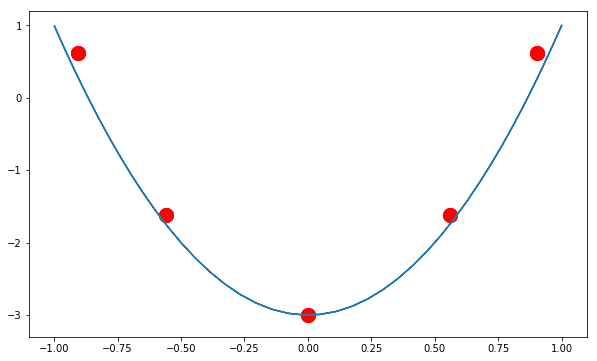

In [114]:
cp_an = 1.0 - 4*(y_cyl/R)**2

plt.figure(figsize=(10,6))
plt.plot(x_cyl,cp_an)
plt.scatter([p.xc for p in panels],[p.cp for p in panels],color='red',s=200)


In [116]:
def integrate_phi(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return 1/((p_i.xc-((p_j.xc) * s))**2 + (p_i.yc-(p_j.yc)*s)**2)
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [119]:
N =100
x_start, x_end = -2.0,2.0
y_start, y_end = -2.0,2.0

xspace = np.linspace(x_start,x_end,N)
yspace = np.linspace(y_start,y_end,N)

[X,Y]= np.meshgrid(xspace,yspace)

for 